In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
PROJECT_ROOT = "/Users/mbgirish/Causal Impact & Uplift Modeling"
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

from preprocessing import (
    ColumnConfig,
    load_marketing_data,
    stratified_train_test_split,
    compute_numeric_balance,
    summarize_treatment_outcome,
)
from causal_models import (
    fit_propensity_score_model,
    ps_stratified_ate,
    ipw_ate,
)

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# ------------------------------------------------------------
# 1. Config & data loading
# ------------------------------------------------------------
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
DATA_FILE = os.path.join(DATA_PATH, "marketing_campaign.csv")  # adjust if needed

column_config = ColumnConfig(
    user_id_col="user_id",
    treatment_col="treatment",
    outcome_col="purchase",  # or "conversion", etc.
)

# Load data - if file doesn't exist, use synthetic data from EDA notebook
if os.path.exists(DATA_FILE):
    _df, column_config = load_marketing_data(DATA_FILE, column_config)
    print(f"✓ Loaded data from {DATA_FILE}")
else:
    # Generate synthetic data (same as EDA notebook)
    print(f"⚠ Data file not found. Generating synthetic data...")
    np.random.seed(42)
    n = 10000
    _df = pd.DataFrame({
        "user_id": [f"user_{i}" for i in range(n)],
        "age": np.random.normal(35, 12, n).clip(18, 80),
        "gender": np.random.choice(["M", "F", "Other"], n, p=[0.48, 0.50, 0.02]),
        "country": np.random.choice(["US", "UK", "CA", "DE", "FR"], n, p=[0.5, 0.2, 0.1, 0.1, 0.1]),
        "sessions_last_30d": np.random.poisson(8, n),
        "orders_last_6m": np.random.poisson(2, n),
        "total_spent_last_6m": np.random.gamma(2, 50, n),
        "recency_days": np.random.exponential(30, n).clip(0, 180),
        "email_subscribed": np.random.choice([0, 1], n, p=[0.3, 0.7]),
        "signup_channel": np.random.choice(["organic", "paid", "referral"], n, p=[0.6, 0.3, 0.1]),
    })
    ps_logit = (
        -2.0
        + 0.05 * (_df["age"] - 35) / 12
        + 0.3 * (_df["sessions_last_30d"] - 8) / 3
        + 0.2 * (_df["orders_last_6m"] - 2)
        - 0.01 * _df["recency_days"] / 30
        + 0.5 * (_df["country"] == "US").astype(int)
    )
    ps = 1 / (1 + np.exp(-ps_logit))
    _df["treatment"] = np.random.binomial(1, ps, n)
    base_prob = (
        0.1
        + 0.02 * (_df["age"] - 35) / 12
        + 0.05 * (_df["sessions_last_30d"] - 8) / 3
        + 0.1 * (_df["orders_last_6m"] - 2)
        - 0.01 * _df["recency_days"] / 30
    )
    treatment_effect = (
        0.15
        + 0.1 * (_df["sessions_last_30d"] > 10).astype(int)
        - 0.05 * (_df["recency_days"] > 60).astype(int)
    )
    purchase_prob = np.clip(base_prob + _df["treatment"] * treatment_effect, 0, 1)
    _df["purchase"] = np.random.binomial(1, purchase_prob, n)
    column_config.numeric_features = ["age", "sessions_last_30d", "orders_last_6m", "total_spent_last_6m", "recency_days"]
    column_config.categorical_features = ["gender", "country", "email_subscribed", "signup_channel"]

print("Shape:", _df.shape)
print("Treatment rate:", _df[column_config.treatment_col].mean())

# Train / test split with stratification on (T, Y)
df_train, df_test = stratified_train_test_split(_df, column_config, test_size=0.3, random_state=42)
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

# Quick sanity check: outcome by treatment (non-causal)
print("\nOutcome by treatment (train):")
print(summarize_treatment_outcome(df_train, column_config))

print("\nOutcome by treatment (test):")
print(summarize_treatment_outcome(df_test, column_config))


✓ Loaded data from /Users/mbgirish/Causal Impact & Uplift Modeling/data/marketing_campaign.csv
Shape: (64000, 10)
Treatment rate: 0.66709375
Train shape: (44800, 10) Test shape: (19200, 10)

Outcome by treatment (train):
               mean       std  count  diff_vs_control_mean
treatment                                                 
control    0.106202  0.308106  14915                   NaN
treated    0.167040  0.373018  29885              0.060839

Outcome by treatment (test):
               mean       std  count  diff_vs_control_mean
treatment                                                 
control    0.106087  0.307973   6391                   NaN
treated    0.167070  0.373053  12809              0.060983


Propensity scores (train):
count    44800.000000
mean         0.667072
std          0.005176
min          0.656851
25%          0.663268
50%          0.666534
75%          0.670306
max          0.699681
Name: ps, dtype: float64


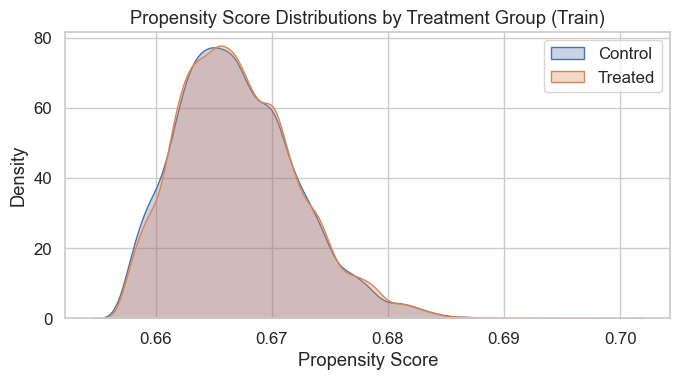


Common support (train):
Treated ps range:  [0.657, 0.700]
Control ps range:  [0.657, 0.700]
Overlap: 0.657 to 0.700


In [2]:
# ------------------------------------------------------------
# 2. Propensity score model (treatment assignment)
# ------------------------------------------------------------

# Fit propensity score model using the reusable function
ps_result = fit_propensity_score_model(
    df_train, df_test, column_config,
    numeric_features=column_config.numeric_features,
    categorical_features=column_config.categorical_features,
)

train = ps_result.train
test = ps_result.test

print("Propensity scores (train):")
print(train["ps"].describe())

# Visualize overlap of propensity scores
plt.figure(figsize=(7, 4))
for t_val, label in [(0, "Control"), (1, "Treated")]:
    sns.kdeplot(
        data=train[train[column_config.treatment_col] == t_val],
        x="ps",
        label=label,
        common_norm=False,
        fill=True,
        alpha=0.3,
    )
plt.title("Propensity Score Distributions by Treatment Group (Train)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Common support check
ps_min_treated = train.loc[train[column_config.treatment_col] == 1, "ps"].min()
ps_max_treated = train.loc[train[column_config.treatment_col] == 1, "ps"].max()
ps_min_control = train.loc[train[column_config.treatment_col] == 0, "ps"].min()
ps_max_control = train.loc[train[column_config.treatment_col] == 0, "ps"].max()

print("\nCommon support (train):")
print(f"Treated ps range:  [{ps_min_treated:.3f}, {ps_max_treated:.3f}]")
print(f"Control ps range:  [{ps_min_control:.3f}, {ps_max_control:.3f}]")
print(f"Overlap: {max(ps_min_treated, ps_min_control):.3f} to {min(ps_max_treated, ps_max_control):.3f}")



Propensity Score Stratification (Approximate Matching) Results:
           ps_bin  n_treated  n_control   bin_ate  bin_n
0  (0.656, 0.661]       2882       1598  0.047000   4480
1  (0.661, 0.663]       3034       1446  0.058566   4480
2  (0.663, 0.664]       2970       1510  0.028990   4480
3  (0.664, 0.665]       2959       1521  0.059831   4480
4  (0.665, 0.667]       3017       1463  0.061727   4480
5  (0.667, 0.668]       2995       1485  0.054684   4480
6   (0.668, 0.67]       3000       1480  0.058414   4480
7   (0.67, 0.671]       3005       1475  0.082848   4480
8  (0.671, 0.674]       2985       1495  0.069606   4480
9    (0.674, 0.7]       3038       1442  0.078593   4480

✓ PSM-stratified ATE (train): 0.0600


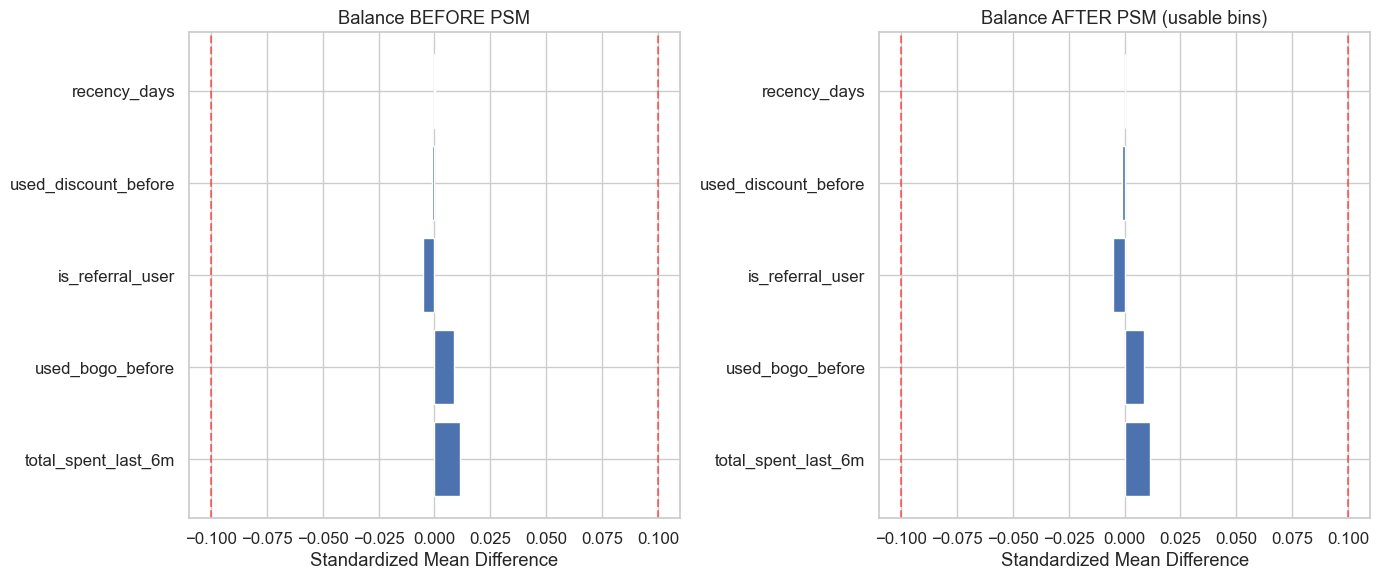


Numeric covariate balance BEFORE PSM (train):
                feature  treated_mean  control_mean  std_mean_diff
1   total_spent_last_6m    243.589021    240.624113       0.011572
3      used_bogo_before      0.550912      0.546497       0.008872
4      is_referral_user      0.501690      0.504257      -0.005135
2  used_discount_before      0.550979      0.551458      -0.000964
0          recency_days      5.760649      5.760375       0.000078

Numeric covariate balance AFTER PSM (train, usable bins only):
                feature  treated_mean  control_mean  std_mean_diff
1   total_spent_last_6m    243.589021    240.624113       0.011572
3      used_bogo_before      0.550912      0.546497       0.008872
4      is_referral_user      0.501690      0.504257      -0.005135
2  used_discount_before      0.550979      0.551458      -0.000964
0          recency_days      5.760649      5.760375       0.000078


In [3]:
# ------------------------------------------------------------
# 3. Propensity Score Matching (via stratification)
# ------------------------------------------------------------

# Use the reusable function for PSM
psm_ate, matched_summary, balance_before, balance_after = ps_stratified_ate(
    train, column_config, ps_col="ps", n_bins=10
)

print("\nPropensity Score Stratification (Approximate Matching) Results:")
print(matched_summary)
print(f"\n✓ PSM-stratified ATE (train): {psm_ate:.4f}")

# Visualize balance improvement
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before PSM
balance_before_plot = balance_before.sort_values("std_mean_diff", key=np.abs, ascending=False)
axes[0].barh(balance_before_plot["feature"], balance_before_plot["std_mean_diff"])
axes[0].axvline(0.1, color="red", linestyle="--", alpha=0.5)
axes[0].axvline(-0.1, color="red", linestyle="--", alpha=0.5)
axes[0].set_title("Balance BEFORE PSM")
axes[0].set_xlabel("Standardized Mean Difference")

# After PSM
balance_after_plot = balance_after.sort_values("std_mean_diff", key=np.abs, ascending=False)
axes[1].barh(balance_after_plot["feature"], balance_after_plot["std_mean_diff"])
axes[1].axvline(0.1, color="red", linestyle="--", alpha=0.5)
axes[1].axvline(-0.1, color="red", linestyle="--", alpha=0.5)
axes[1].set_title("Balance AFTER PSM (usable bins)")
axes[1].set_xlabel("Standardized Mean Difference")

plt.tight_layout()
plt.show()

print("\nNumeric covariate balance BEFORE PSM (train):")
print(balance_before)
print("\nNumeric covariate balance AFTER PSM (train, usable bins only):")
print(balance_after)



✓ IPW ATE estimate (train, stabilized & truncated): 0.0592


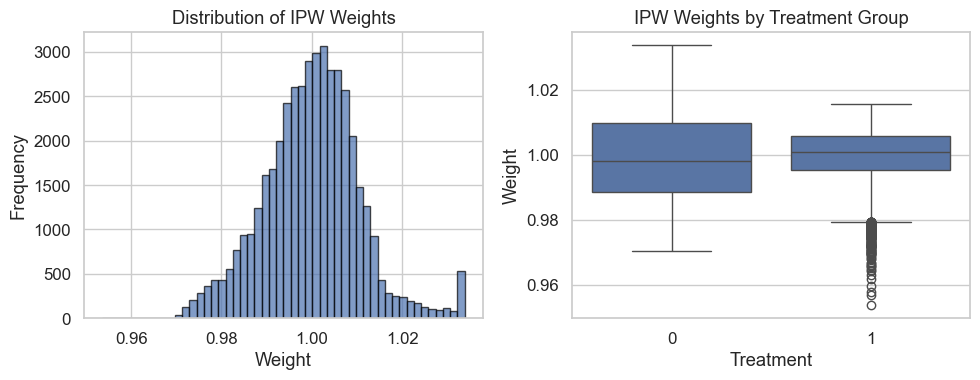


Numeric covariate balance AFTER IPW (train, weighted):
                feature  treated_mean  control_mean  std_mean_diff
1   total_spent_last_6m    242.610401    242.420681       0.011572
3      used_bogo_before      0.549445      0.549313       0.008872
4      is_referral_user      0.502539      0.502502      -0.005135
2  used_discount_before      0.551134      0.551045      -0.000964
0          recency_days      5.760512      5.760987       0.000078


In [4]:
# ------------------------------------------------------------
# 4. Inverse Propensity Weighting (IPW)
# ------------------------------------------------------------

# Use the reusable function for IPW
# Note: ipw_ate modifies train DataFrame in place to add "ipw_weight" column
ate_ipw, balance_ipw = ipw_ate(
    train, column_config, ps_col="ps", stabilized=True, truncate_quantile=0.99
)

print(f"\n✓ IPW ATE estimate (train, stabilized & truncated): {ate_ipw:.4f}")

# Visualize IPW weights (ipw_weight column is now in train DataFrame)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train["ipw_weight"], bins=50, alpha=0.7, edgecolor="black")
plt.title("Distribution of IPW Weights")
plt.xlabel("Weight")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(data=train, x=column_config.treatment_col, y="ipw_weight")
plt.title("IPW Weights by Treatment Group")
plt.xlabel("Treatment")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

print("\nNumeric covariate balance AFTER IPW (train, weighted):")
print(balance_ipw)


## 5. Comparison of Causal Estimates

Let's compare all our causal estimates:


Comparison of Treatment Effect Estimates:
          Method      ATE
  Naive (biased) 0.060839
  PSM-stratified 0.060026
IPW (stabilized) 0.059165


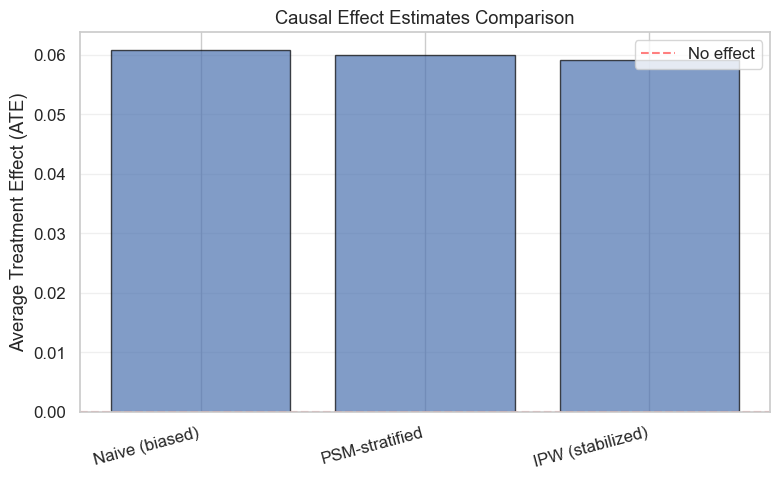


✓ Key takeaway:
  - Naive estimate is biased due to confounding
  - PSM and IPW adjust for observed confounders
  - If estimates differ significantly, investigate unmeasured confounding


In [10]:
# Compare all estimates
naive_ate = (
    train[train[column_config.treatment_col] == 1][column_config.outcome_col].mean()
    - train[train[column_config.treatment_col] == 0][column_config.outcome_col].mean()
)

results = pd.DataFrame({
    "Method": ["Naive (biased)", "PSM-stratified", "IPW (stabilized)"],
    "ATE": [naive_ate, psm_ate, ate_ipw],
})

print("Comparison of Treatment Effect Estimates:")
print(results.to_string(index=False))

# Visualize
plt.figure(figsize=(8, 5))
bars = plt.bar(results["Method"], results["ATE"], alpha=0.7, edgecolor="black")
plt.axhline(0, color="red", linestyle="--", alpha=0.5, label="No effect")
plt.ylabel("Average Treatment Effect (ATE)")
plt.title("Causal Effect Estimates Comparison")
plt.xticks(rotation=15, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Key takeaway:")
print("  - Naive estimate is biased due to confounding")
print("  - PSM and IPW adjust for observed confounders")
print("  - If estimates differ significantly, investigate unmeasured confounding")
